In [183]:
from math import sin, cos, pi, sqrt, e, log, isclose, exp
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm, pyplot as plt

import h5py
from scipy.constants import epsilon_0, mu_0
import scipy.constants

import Levenshtein as lev
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from fdtd_PCB_extensions.tissue import cole_cole_4, complex_permittivity_to_er_and_sigma, electric_field_penetration_depth


In [184]:
tissue_properties_database_file = '../biology/FDTD/itis_tissue_properties/SEMCAD_v14.8.h5'

tissue_obj = 0
f = h5py.File(tissue_properties_database_file,'r')
#Fuzzy matching names - keep a close eye on this, errors could creep in!
virtprop_name = "Lung"
matching_name = process.extractOne(virtprop_name,f['Tissues'].keys())
print(f"Fuzzy-matched tissue {virtprop_name} to {matching_name[0]}")

tissue_obj = f['Tissues'][matching_name[0]]


taus = np.array([0]*4,dtype=np.float)
alphas = np.array([0]*4,dtype=np.float)
deltas = np.array([0]*4,dtype=np.float)

taus[0] = tissue_obj.attrs["tau1"]
taus[1] = tissue_obj.attrs["tau2"]
taus[2] = tissue_obj.attrs["tau3"]
taus[3] = tissue_obj.attrs["tau4"]

# Tau values in the tissueprop files are normalized
# Tau1 is normalized by 1e-12
# tau2 1e-9
# tau3 1e-6
# tau4 1e-3
tau_normalization_factors = np.array([1e-12, 1e-9, 1e-6, 1e-3])
# all other constants are not normalized.
taus *= tau_normalization_factors

alphas[0] = tissue_obj.attrs["alf1"]
alphas[1] = tissue_obj.attrs["alf2"]
alphas[2] = tissue_obj.attrs["alf3"]
alphas[3] = tissue_obj.attrs["alf4"]

deltas[0] = tissue_obj.attrs["del1"]
deltas[1] = tissue_obj.attrs["del2"]
deltas[2] = tissue_obj.attrs["del3"]
deltas[3] = tissue_obj.attrs["del4"]

sigma = tissue_obj.attrs["sig"]
ef = tissue_obj.attrs["ef"]



Fuzzy-matched tissue Lung to Lung


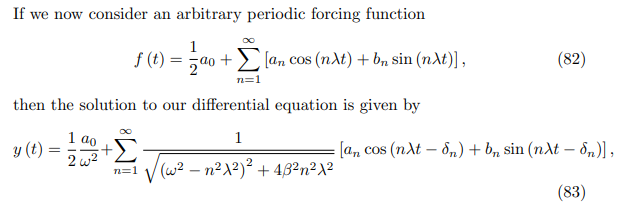


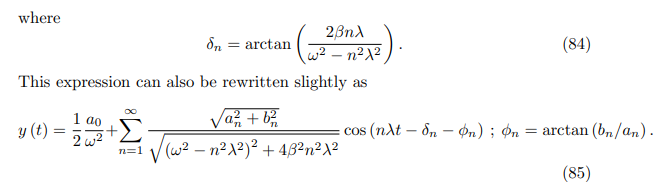

In [185]:
def fourier_amplitude_coefficients(fundamental_period, pulse_duration, N):
    # https://lpsa.swarthmore.edu/Fourier/Series/ExFS.html#EvenPulse

    n = np.arange(1, N+1)
    a_n = 2.0*(1.0/(n[1:]*pi))*np.sin(n[1:]*pi*(pulse_duration / fundamental_period))
#     a_n = np.insert(a_n, 0, (pulse_duration / fundamental_period))
    
    return a_n

fourier_amplitude_coefficients(2, 1, 7) #verified


array([ 3.898172e-17, -2.122066e-01, -3.898172e-17,  1.273240e-01,
        3.898172e-17, -9.094568e-02])

In [189]:
def fourier_sum(fundamental_period, mode_phases, amplitude_coefficients, t, N):
    n = np.arange(1, N+1)
    return np.sum(amplitude_coefficients*np.cos(n*((1.0/fundamental_period)*2.0*pi * t) - mode_phases), axis=0)

N=3

amplitude_coefficients = fourier_amplitude_coefficients(2, 1, N) 

mode_phases = np.zeros_like(amplitude_coefficients)

t = np.linspace(-2.0, 2.0, 1000)

dt = []
for i in t:
    dt.append(fourier_sum(2, mode_phases, amplitude_coefficients, i, N))

plt.plot(dt)


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [ ]:
def simple_dispersion(t, x, fundamental_period, N):

    n = np.arange(1, N+1)
    modes = (1.0/fundamental_period)*n
    dielectric_constants = np.zeros_like(modes, dtype=np.float)
    E_penetration_depths = np.zeros_like(modes, dtype=np.float)

    for idx,mode in enumerate(modes):
            
        cole_cole_properties = cole_cole_4(mode, ef, sigma, deltas, alphas, taus)
        dielectric_constant, conductivity = complex_permittivity_to_er_and_sigma(cole_cole_properties, mode)

        dielectric_constants[idx] = dielectric_constant
        E_penetration_depth = electric_field_penetration_depth(mode, dielectric_constant, conductivity)
        E_penetration_depths[idx] = E_penetration_depth

    spatial_wavenumbers = modes * 2.0 * pi * np.sqrt(mu_0 * epsilon_0 * dielectric_constants)

    return spatial_wavenumbers, E_penetration_depths


t= 0
x = 0
fundamental_period = 1e-10
N = 5

spatial_wavenumbers, E_penetration_depths = simple_dispersion(t, x, fundamental_period, N)

spatial_wavenumbers

In [188]:


t= 0
x = 0.0
fundamental_period = (1/5e9)
N = 100

amplitude_coefficients = fourier_amplitude_coefficients(fundamental_period, fundamental_period/10.0, N) 

spatial_wavenumbers, E_penetration_depths = simple_dispersion(t, x, fundamental_period, N)

amplitude_coefficients[1:] *= np.exp(- x / E_penetration_depths[1:])
amplitude_coefficients[0] = 0
mode_phases = spatial_wavenumbers * x
# mode_phases = np.zeros_like(mode_phases)

t = np.linspace(-fundamental_period, fundamental_period, 1000)

dt = []
for i in t:
    dt.append(fourier_sum(fundamental_period, mode_phases, amplitude_coefficients, i, N)-fourier_sum(fundamental_period, mode_phases, amplitude_coefficients, i, N))

plt.plot(dt)

ValueError: operands could not be broadcast together with shapes (98,) (99,) (98,) 